# Pylops - seismic inversion with non-stationary wavelet

### Author: M.Ravasi

In this notebook we consider the post-stack inverse problem using a non-stationary wavelet.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *

Create velocity and density profiles

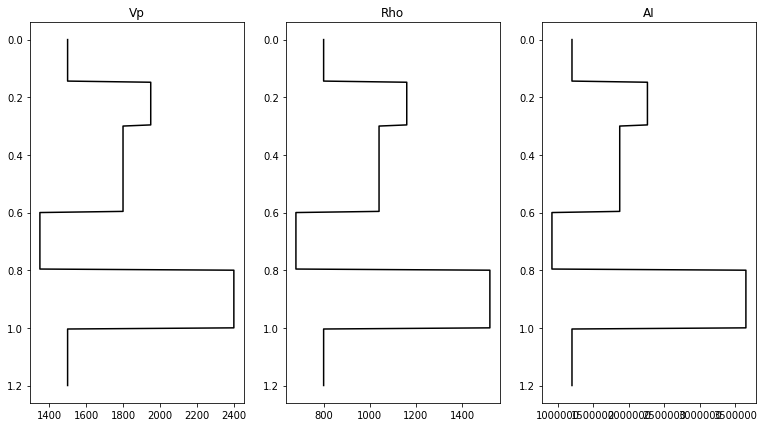

In [53]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
#vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
#rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
#vp[131:]+=500
#rho[131:]+=100

vp = 1500 * np.ones(nt0)
vp[nt0//8:nt0//4] *= 1.3
vp[nt0//4:nt0//2] *= 1.2
vp[nt0//2:2*nt0//3] *= 0.9
vp[2*nt0//3:nt0-50] *= 1.6
rho = 0.8 * (vp - 500)

fig, axs = plt.subplots (1, 3, figsize=(13,7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()
axs[2].plot(rho*vp, t0, 'k')
axs[2].set_title('AI')
axs[2].invert_yaxis()

Define wavelets

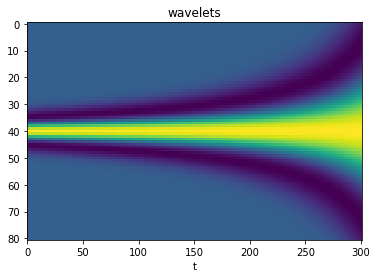

In [54]:
ntwav = 41
f0s = np.flip(np.arange(nt0) * 0.05 + 3)
wavs = np.array([ricker(t0[:ntwav], f0)[0] for f0 in f0s])
wavc = np.argmax(wavs[0])

plt.figure()
plt.imshow(wavs.T)
plt.xlabel('t')
plt.title('wavelets');
plt.axis('tight');

## Post-stack inversion - 1D

In [79]:
m1d = np.log(vp*rho).flatten()

# lop
PPop = PoststackLinearModelling(wavs, nt0=nt0)
dottest(PPop, nt0, nt0, verb=True)

# dense
PPop_dense = PoststackLinearModelling(wavs, nt0=nt0, explicit=True)
dottest(PPop_dense, nt0, nt0, verb=True)

# data
d = (PPop*m1d)
d_dense = (PPop_dense*m1d.flatten())
dn_dense = d_dense + np.random.normal(0, 8e-2, d_dense.shape)

301
Dot test passed, v^T(Opu)=0.631958 - u^T(Op^Tv)=0.631958
301
(301, 301)
Dot test passed, v^T(Opu)=1.268667 - u^T(Op^Tv)=1.268667


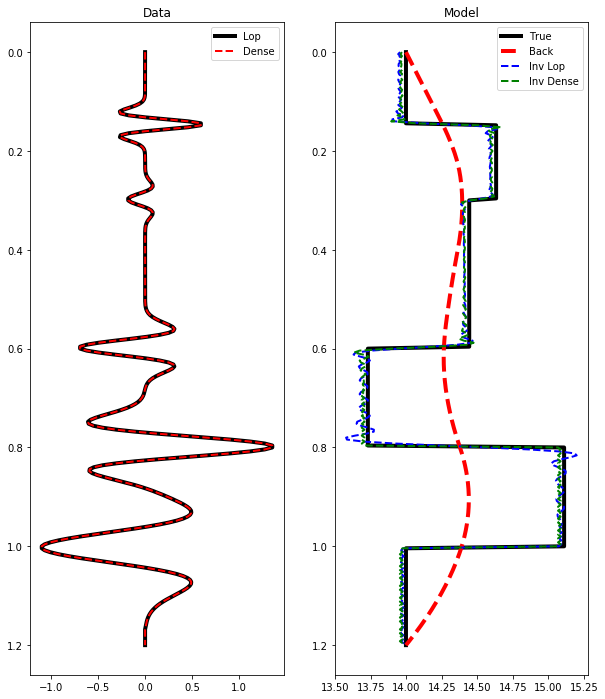

In [66]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d)

# solve lop
d0 = PPop*m1dback
dr = d - d0
minv = lsqr(PPop, dr, iter_lim=2000)[0]
minv = m1dback + minv

# solve dense
d0_dense = PPop*m1dback
dr_dense = d_dense - d0_dense
minv_dense = lstsq(PPop_dense.A, dr_dense, cond=1e-10)[0]
minv_dense = m1dback + minv_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=2, label='Inv Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

Dot test passed, v^T(Opu)=1.581608 - u^T(Op^Tv)=1.581608
Dot test passed, v^T(Opu)=-1.117818 - u^T(Op^Tv)=-1.117818
Dot test passed, v^T(Opu)=-9.499351 - u^T(Op^Tv)=-9.499351


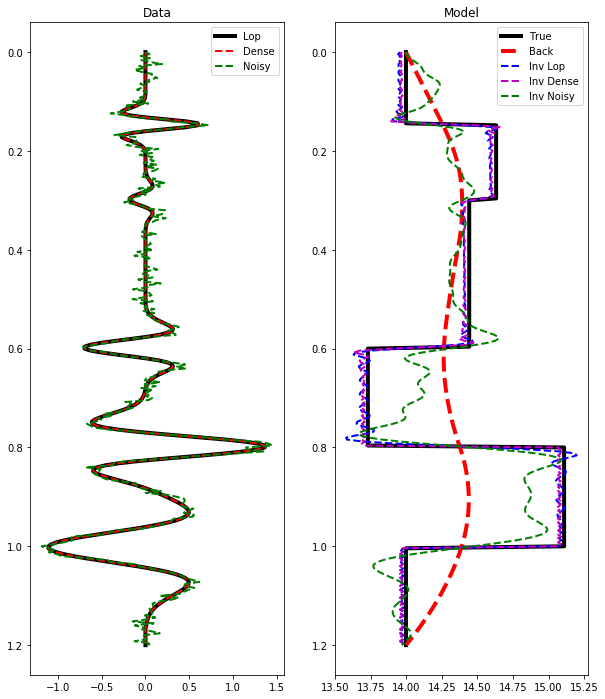

In [67]:
minv_dense = PoststackInversion(d, wavs, m0=m1dback, explicit=True, simultaneous=False, dottest=True,
                                **dict(cond=1e-10))[0]

minv = PoststackInversion(d_dense, wavs, m0=m1dback, explicit=False, simultaneous=False, dottest=True,
                          **dict(iter_lim=2000))[0]

minv_noise = PoststackInversion(dn_dense, wavs, m0=m1dback, explicit=True, 
                                epsR=4e0, dottest=True, **dict(damp=1e-1))[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].plot(dn_dense, t0,'--g', lw=2, label='Noisy')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(minv_noise, t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

## Post-stack inversion - 2D

In [68]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

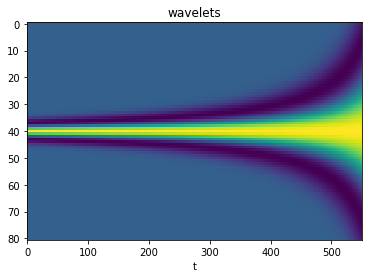

In [90]:
ntwav = 41
f0s = np.flip(np.arange(nz) * 0.05 + 3)
wavs = np.array([ricker(t0[:ntwav], f0)[0] for f0 in f0s])
wavc = np.argmax(wavs[0])

plt.figure()
plt.imshow(wavs.T)
plt.xlabel('t')
plt.title('wavelets');
plt.axis('tight');

Create operators

In [93]:
# lop
PPop = PoststackLinearModelling(wavs, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop, nz*nx, nz*nx, verb=True, tol=1e-3)

# dense
PPop_dense = PoststackLinearModelling(wavs, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop_dense, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)
print((d - d_dense).max())

n = np.random.normal(0, 1e-1, d_dense.shape)
dn = d + n
dn_dense = d_dense + n

Dot test passed, v^T(Opu)=-1648.918022 - u^T(Op^Tv)=-1648.918022
Dot test passed, v^T(Opu)=-425.096013 - u^T(Op^Tv)=-425.096013
9.43689570931383e-16


In [94]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d_0_dense = PPop_dense*mback.flatten()
d_0_lop = PPop*mback.flatten()

Adjoints

In [95]:
madj_dense = PPop_dense.H*d_dense.flatten()
madj = PPop.H*d.flatten()
print((madj - madj_dense).max())

4.551914400963142e-15


Different inversion choices with dense operator

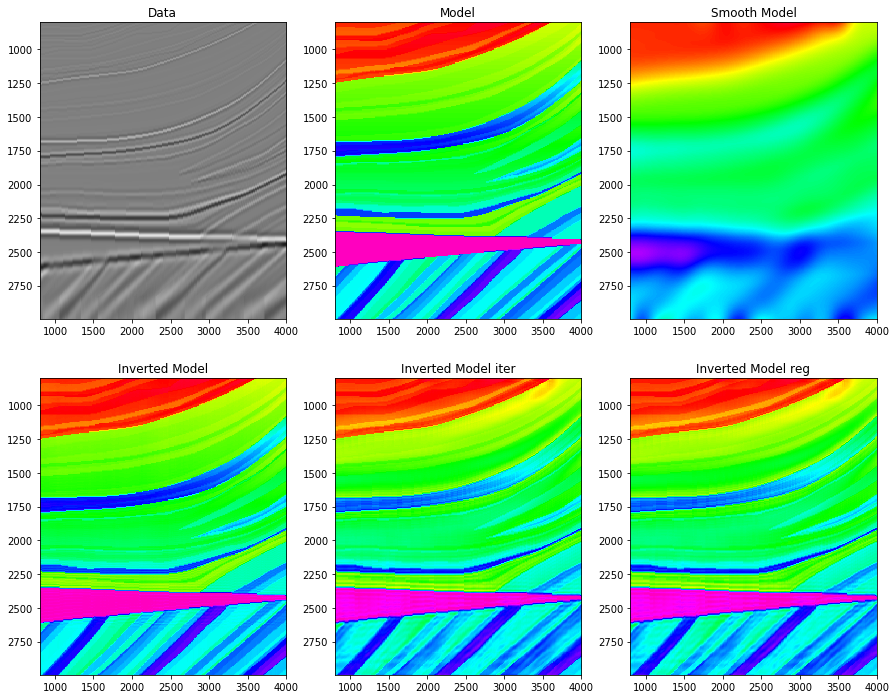

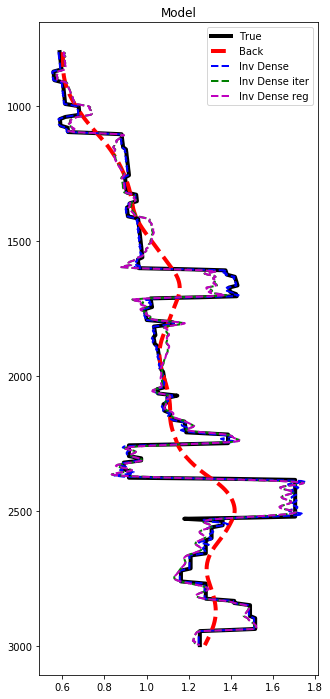

In [96]:
# solve all rows indipendently
d_r_dense = d_dense - d_0_dense.reshape(nz,nx)
minv_dense = lstsq(PPop_dense.A, d_r_dense, cond=1e-6)[0]
minv_dense = mback + minv_dense

# solve all rows together
d_r_dense_iter = d_dense - d_0_dense.reshape(nz,nx)
minv_dense_iter = lsqr(PPop_dense, d_r_dense_iter.flatten(), iter_lim=100)[0]
minv_dense_iter = minv_dense_iter.reshape(nz, nx)
minv_dense_iter = mback + minv_dense_iter.reshape(nz, nx)

# solve all rows together with regularization
D2op  = Laplacian([nz, nx], dtype='float64')

minv_dense_reg = NormalEquationsInversion(PPop_dense, [D2op], d_r_dense.flatten(),
                                          epsRs=[np.sqrt(1e-4)], returninfo=False,
                                          **dict(maxiter=100))
#minv_dense_reg = RegularizedInversion(PPop_dense, [D2op], d_r_dense.flatten(),
#                                      epsRs=[np.sqrt(1e-4)], returninfo=False,
#                                      **dict(iter_lim=100, show=0))
minv_dense_reg = mback + minv_dense_reg.reshape(nz, nx)


fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_iter, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_dense_reg, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_iter[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(minv_dense_reg[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Use function

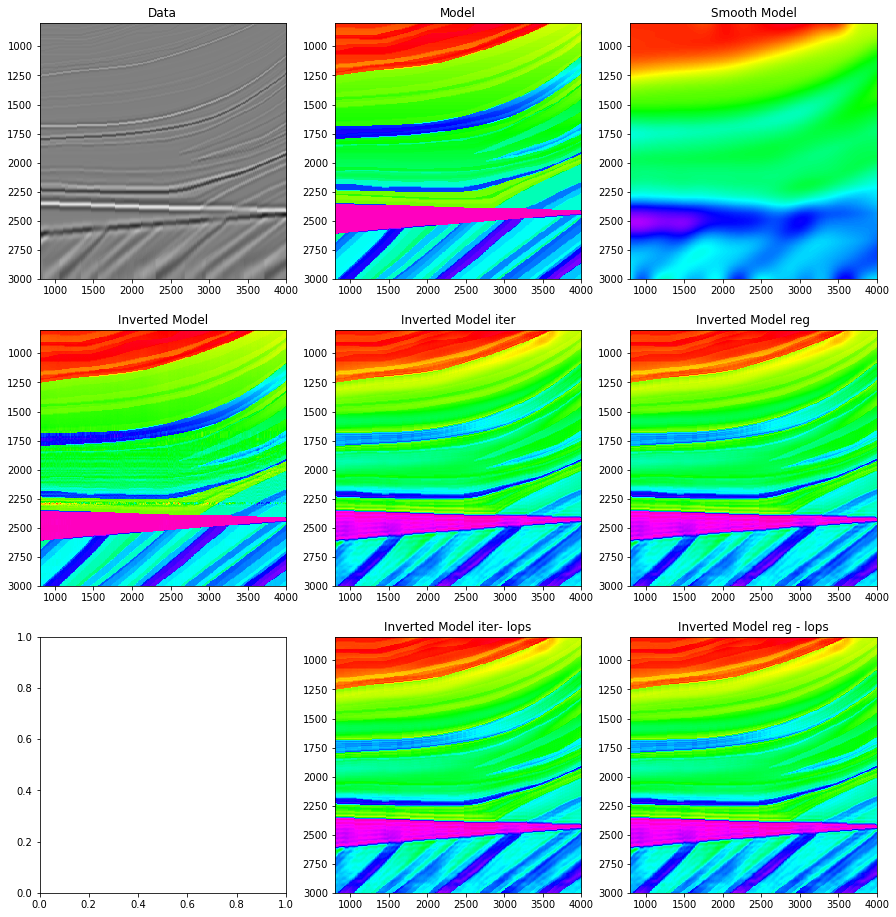

In [99]:
minv_dense_f, dr_dense_f = PoststackInversion(d_dense, wavs, m0=mback, explicit=True, simultaneous=False)
minv_dense_iter_f, dr_dense_iter_f = PoststackInversion(d_dense, wavs, m0=mback, explicit=True, simultaneous=True, 
                                                        **dict(iter_lim=50))
minv_dense_reg_f, dr_dense_reg_f = PoststackInversion(d_dense, wavs, m0=mback, explicit=True, epsR=np.sqrt(1e-4), 
                                                      **dict(damp=np.sqrt(1e-4), iter_lim=50))
minv_lop_iter_f, dr_lop_iter_f = PoststackInversion(d, wavs, m0=mback, explicit=False, 
                                                    **dict(iter_lim=50))
minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(d, wavs, m0=mback, explicit=False, epsR=np.sqrt(1e-4), 
                                                  **dict(damp=np.sqrt(1e-4), iter_lim=50))


fig, axs = plt.subplots(3, 3, figsize=(15,16))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv_dense_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_iter_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_dense_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');
axs[2][1].imshow(minv_lop_iter_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][1].set_title('Inverted Model iter- lops')
axs[2][1].axis('tight');
axs[2][2].imshow(minv_lop_reg_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[2][2].set_title('Inverted Model reg - lops')
axs[2][2].axis('tight');

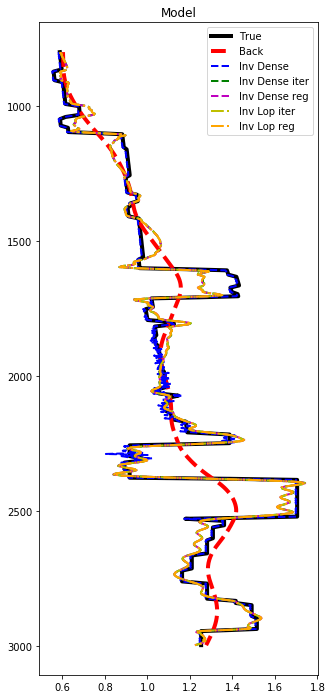

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense_f[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_iter_f[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(minv_dense_reg_f[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.plot(minv_lop_iter_f[:,nx//2], z, '-.y', lw=2, label='Inv Lop iter')
ax.plot(minv_lop_reg_f[:,nx//2], z, 'orange', ls='-.', lw=2, label='Inv Lop reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();